# <center> Feature Selection </center>

Feature selection is one of the first and important steps while performing any machine learning task. A feature in case of a dataset simply means a column. When we get any dataset, not necessarily every column (feature) is going to have an impact on the output variable. If we add these irrelevant features in the model, it will just make the model worst (Garbage In Garbage Out). This gives rise to the need of doing feature selection.

Feature selection can be done in multiple ways but there are broadly 3 categories of it:
     1. Filter Method
     2. Wrapper Method
     3. Embedded Method

In [1]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

In [2]:
#Loading the dataset
from sklearn.datasets import load_boston
x = load_boston()
df = pd.DataFrame(x.data, columns = x.feature_names)
df["MEDV"] = x.target
X = df.drop("MEDV",1)   #Feature Matrix
y = df["MEDV"]          #Target Variable
print(df.shape)
df.head()

(506, 14)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


---
## 1. Filter Method
### Using Pearson's Correlation

As the name suggest, in this method, we filter and take only the subset of the relevant features. The model is built after selecting the features. The filtering here is done using correlation matrix and it is most commonly done using Pearson correlation.

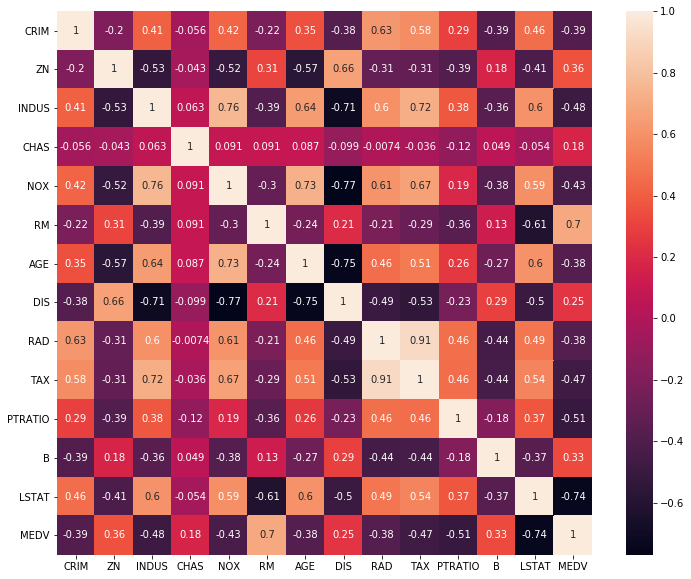

In [3]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = df.corr()
sns.heatmap(cor, annot=True)
plt.show()

In [4]:
#Correlation with output variable
cor_target = abs(cor["MEDV"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.5]
relevant_features

RM         0.695360
PTRATIO    0.507787
LSTAT      0.737663
MEDV       1.000000
Name: MEDV, dtype: float64

In [5]:
df_filtered = df[['RM','PTRATIO','LSTAT','MEDV']]
print(df_filtered.shape)
df_filtered.head()

(506, 4)


,RM,PTRATIO,LSTAT,MEDV
0,6.575,15.3,4.98,24.0
1,6.421,17.8,9.14,21.6
2,7.185,17.8,4.03,34.7
3,6.998,18.7,2.94,33.4
4,7.147,18.7,5.33,36.2


---

## 2. Wrapper Method

A wrapper method needs one machine learning algorithm and uses its performance as evaluation criteria. This means, you feed the features to the selected Machine Learning algorithm and based on the model performance you add/remove the features. This is an iterative and computationally expensive process but it is more accurate than the filter method.

There are different wrapper methods such as **Backward Elimination**, **Forward Selection** and **Recursive Feature Elemination (RFE)**.

### Backward Elimination

In [6]:
#Adding constant column of ones, mandatory for sm.OLS model
X_1 = sm.add_constant(X)
#Fitting sm.OLS model
model = sm.OLS(y,X_1).fit()
model.pvalues

const      3.283438e-12
CRIM       1.086810e-03
ZN         7.781097e-04
INDUS      7.382881e-01
CHAS       1.925030e-03
NOX        4.245644e-06
RM         1.979441e-18
AGE        9.582293e-01
DIS        6.013491e-13
RAD        5.070529e-06
TAX        1.111637e-03
PTRATIO    1.308835e-12
B          5.728592e-04
LSTAT      7.776912e-23
dtype: float64

In [7]:
#Backward Elimination
cols = list(X.columns)
pmax = 1
while (len(cols)>0):
    X_1 = X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
selected_features_BE = cols
print(selected_features_BE)

['CRIM', 'ZN', 'CHAS', 'NOX', 'RM', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']


### Forward Selection

In [8]:
# Forward Selection
cols_total = list(X.columns)
cols = []
pmax = 1
i = 0
while (len(cols)<len(cols_total)):
    new_cols = cols_total[i]
    cols = cols + [new_cols]
    X_1 = X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        break
    i += 1
selected_features_BE = cols
print(selected_features_BE)

['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX']


### Recursive Feature Elimination (RFE)

The *Recursive Feature Elimination (RFE)* method works by recursively removing attributes and building a model on those attributes that remain. It uses accuracy metric to rank the feature according to their importance. The RFE method takes the model to be used and the number of required features as input. It then gives the ranking of all the variables, 1 being most important. It also gives its support, True being relevant feature and False being irrelevant feature.

In [9]:
model = LinearRegression()
#Initializing RFE model
rfe = RFE(model,n_features_to_select=7)
#Transforming data using RFE
X_rfe = rfe.fit_transform(X,y)  
#Fitting the data to model
model.fit(X_rfe,y)
print(rfe.support_)
print(rfe.ranking_)

[False False False  True  True  True False  True  True False  True False
  True]
[2 4 3 1 1 1 7 1 1 5 1 6 1]


In [10]:
#no of features
feat_list=np.arange(1,13)            
high_score=0
#Variable to store the optimum features
nfeat=0           
score_list =[]
for n in range(len(feat_list)):
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2,random_state=0)
    model = LinearRegression()
    rfe = RFE(model,n_features_to_select=feat_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nfeat = feat_list[n]
print("Optimum number of features: %d" %nfeat)
print("Score with %d features: %f" % (nfeat, high_score))


Optimum number of features: 12
Score with 12 features: 0.589689


In [11]:
cols = list(X.columns)
model = LinearRegression()
#Initializing RFE model
rfe = RFE(model, n_features_to_select=12)             
#Transforming data using RFE
X_rfe = rfe.fit_transform(X,y)  
#Fitting the data to model
model.fit(X_rfe,y)              
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT'],
      dtype='object')


---
## 3. Embedded Method

Embedded methods are iterative in a sense that takes care of each iteration of the model training process and carefully extract those features which contribute the most to the training for a particular iteration. Regularization methods are the most commonly used embedded methods which penalize a feature given a coefficient threshold.

In [12]:
from sklearn.linear_model import LassoCV
reg = LassoCV()
reg.fit(X, y)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(X,y))
coef = pd.Series(reg.coef_, index = X.columns)

Best alpha using built-in LassoCV: 0.724820
Best score using built-in LassoCV: 0.702444


In [13]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 10 variables and eliminated the other 3 variables


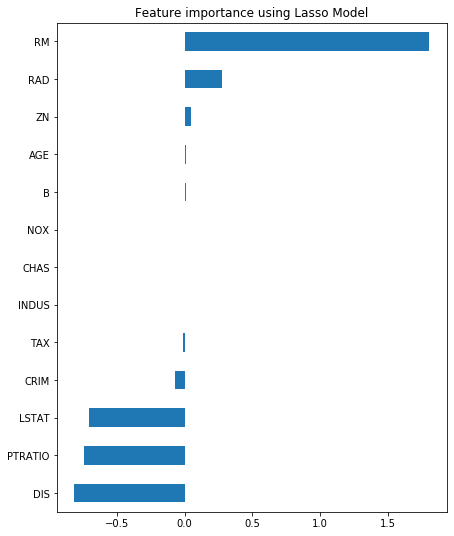

In [17]:
imp_coef = coef.sort_values()
plt.figure(figsize=(7,9))
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")
plt.show()